# Objective

Build an AI agent based on **LangGraph** to process emails from the regulators to an real estate development company. The agent extracts critical information and notifies the correct internal team who will take action.

## Example

* [LangGraph: Build Stateful AI Agents in Python](https://realpython.com/langgraph-python/#reader-comments)


In [1]:
import os
import json
import logging
from datetime import datetime, date
from typing import TypedDict

from IPython.display import Image, display
from pydantic import BaseModel, Field, computed_field, EmailStr

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph

In [2]:
%load_ext autoreload
%autoreload 2

from extract_regulatory_notice import (
    NoticeEmailExtract,
    EscalationCheck,
)
from data import (
    EMAILS
)

# Data (Regulatory Email)

In [3]:
email = EMAILS[0]
print(f"{email}")


    Date: October 15, 2024
    From: Occupational Safety and Health Administration (OSHA)
    To: Blue Ridge Construction, project 111232345 - Downtown Office
    Complex Location: Dallas, TX

    During a recent inspection of your construction site at 123 Main
    Street,
    the following safety violations were identified:

    Lack of fall protection: Workers on scaffolding above 10 feet
    were without required harnesses or other fall protection
    equipment. Unsafe scaffolding setup: Several scaffolding
    structures were noted as
    lacking secure base plates and bracing, creating potential
    collapse risks.
    Inadequate personal protective equipment (PPE): Multiple
    workers were
    found without proper PPE, including hard hats and safety
    glasses.
    Required Corrective Actions:

    Install guardrails and fall arrest systems on all scaffolding
    over 10 feet. Conduct an inspection of all scaffolding
    structures and reinforce unstable sections. Ensure all
 

# OpenAI

In [4]:
path_to_openai_key:str = os.path.expanduser('~/.openai/api_key')
with open(path_to_openai_key, 'r', encoding='utf-8') as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()

# Model

In [5]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt

```regulatory_email_parse_prompt``` prompt recieves an email as the ```message``` parameter and defines instructs LLM what to do.

In [6]:
regulatory_email_parse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            Parse the date of notice, sending entity name, sending entity
            phone, sending entity email, project id, site location,
            violation type, required changes, compliance deadline, and
            maximum potential fine from the message. If any of the fields
            aren't present, don't populate them. Try to cast dates into
            the YYYY-mm-dd format. Don't populate fields if they're not
            present in the message.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

# Structured Output Definition

Pydantic class ```NoticeEmailExtract``` defines the structured out and the fields to extract. LangChain will pass the fields as raw text to an LLM to extract them. See [Pydantic class output](https://python.langchain.com/docs/how_to/structured_output/#pydantic-class).

* [How to use output parsers to parse an LLM response into structured format](https://python.langchain.com/docs/how_to/output_parser_structured/)
* [How to return structured data from a model](https://python.langchain.com/docs/how_to/structured_output/)

> The ```.with_structured_output()``` method takes a **schema** as input which specifies the names, types, and descriptions of the desired output attributes. Then outputs objects corresponding to the given **schema**.
>
> TypedDict class, JSON Schema or a Pydantic class can be used as the **schema**.

# Processing Chains

## Extraction Chain

1. injects an email into the ```message``` parameter of ```regulatory_email_parse_prompt```. 
2. passes the output of ```regulatory_email_parse_prompt``` to LangChain.
3. based on ```.with_structured_output(NoticeEmailExtract)```, LangChain converts ```NoticeEmailExtract``` to a prompt to extract the defined fields.
4. LangChain passes the parser output to LLM with the prompts.


In [7]:
PRRSE_REGULATORY_EMAIL_CHAIN = (
    regulatory_email_parse_prompt
    | model.with_structured_output(NoticeEmailExtract)
)

In [8]:
# PRRSE_REGULATORY_EMAIL_CHAIN.get_graph()

In [9]:
extracted: NoticeEmailExtract = PRRSE_REGULATORY_EMAIL_CHAIN.invoke({"message": email})

In [10]:
print(json.dumps(extracted.model_dump(), indent=4, default=str))

{
    "entity_name": "Occupational Safety and Health Administration (OSHA)",
    "entity_phone": "(555) 123-4567",
    "entity_email": "compliance.osha@osha.gov",
    "project_id": 111232345,
    "site_location": "123 Main Street, Dallas, TX",
    "violation_type": "Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)",
    "required_changes": "Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaffolding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PPE and conduct safety training on proper usage.",
    "max_potential_fine": 25000.0,
    "date_of_notice": "2024-10-15",
    "compliance_deadline": "2024-11-10"
}


## Decision Chain

1. injects an email into the ```message``` parameter of ```check_escalation_required_prompt```.
2. passes the output of ```check_escalation_required_prompt``` to LangChain.
3. based on ```.with_structured_output(NoticeEmailExtract)```, LangChain converts ```NoticeEmailExtract``` to a prompt to extract the defined fields.
4. LangChain passes the parser output to LLM with the prompts.

In [11]:
check_escalation_required_prompt = ChatPromptTemplate.from_messages(    [
        (
            "system",
            """
            Determine whether the following notice received
            from a regulatory body requires immediate escalation.
            Immediate escalation is required when {escalation_criteria}.

            Here's the notice message:

            {message}
            """,
        )
    ]
)

In [12]:
CHECK_ESCALATION_REQUIRED_CHAIN = (
        check_escalation_required_prompt
        | model.with_structured_output(EscalationCheck)
)

---
# LangGraph

## Limitation of Chain and requirement of Graph

Chains is not designed to handle state or make conditional decision. 

## Agent on LangGraph

**LangGraph** is an approach to implementa an agent that can reason and decide as a state machine (like a human) using LLM for the reasoning and decision engine. It defines a graph where node is an action and edge is the decisional transfer to next action.

* Node = { id, handler } — handler: pure function (state, input) -> (outputs, side_effects?).
* Edge = { from, to, guard, action?, priority } — guard: (state, input) -> bool. action optional for transition side-effects.
* Graph = nodes + edges + start_node(s) + terminal nodes.
* State = a serializable dict (single source of truth), persisted if needed.
 Now that you’ve built the notice parsing and escalation check chains, you need to orchestrate them

In [13]:
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
LOGGER = logging.getLogger(__name__)

## State (Memory of Agent)

In [14]:
class GraphState(TypedDict):
    notice_message: str
    notice_email_extract: NoticeEmailExtract | None
    escalation_text_criteria: str
    escalation_dollar_criteria: float
    requires_escalation: bool
    escalation_emails: list[EmailStr] | None
    follow_ups: dict[str, bool] | None
    current_follow_up: str | None

In [15]:
state_machine = StateGraph(GraphState)

initial_state = {
    "notice_message": EMAILS[0],
    "notice_email_extract": None,
    "escalation_text_criteria": """There's a risk of fire or
    water damage at the site""",
    "escalation_dollar_criteria": 100_000,
    "requires_escalation": False,
    "escalation_emails": ["brog@abc.com", "bigceo@company.com"],
}

## Graph Nodes (Action/Function)

In [16]:
def parse_notice_message_node(state: GraphState) -> GraphState:
    """Use the notice parser chain to extract fields from the notice"""
    LOGGER.info("Parsing notice...")
    notice_email_extract = PRRSE_REGULATORY_EMAIL_CHAIN.invoke(
        {"message": state["notice_message"]}
    )
    state["notice_email_extract"] = notice_email_extract
    return state

def check_escalation_status_node(state: GraphState) -> GraphState:
    """Determine whether a notice needs escalation"""
    LOGGER.info("Determining escalation status...")
    text_check = CHECK_ESCALATION_REQUIRED_CHAIN.invoke(
        {
            "escalation_criteria": state["escalation_text_criteria"],
            "message": state["notice_message"],
        }
    ).needs_escalation

    if (
        text_check
        or state["notice_email_extract"].max_potential_fine
        >= state["escalation_dollar_criteria"]
    ):
        state["requires_escalation"] = True
    else:
        state["requires_escalation"] = False

    return state

In [17]:
state_machine.add_node("parse_notice_message", parse_notice_message_node)
state_machine.add_node("check_escalation_status", check_escalation_status_node)

state_machine.add_edge(START, "parse_notice_message")
state_machine.add_edge("parse_notice_message", "check_escalation_status")
state_machine.add_edge("check_escalation_status", END)

In [18]:
PROCESS_REGULATION_NOTICE_AGENT = state_machine.compile()

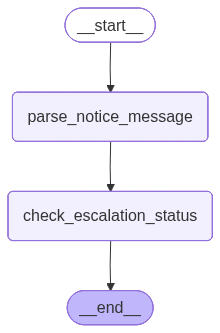

In [19]:
display(Image(PROCESS_REGULATION_NOTICE_AGENT.get_graph().draw_mermaid_png()))

## Execution

In [21]:
final_state = PROCESS_REGULATION_NOTICE_AGENT.invoke(initial_state)

2025-10-06 20:38:05,206 - INFO - Parsing notice...
2025-10-06 20:38:10,815 - INFO - Determining escalation status...


In [22]:
print(json.dumps(final_state["notice_email_extract"].model_dump(), indent=2, default=str))

{
  "entity_name": "Occupational Safety and Health Administration (OSHA)",
  "entity_phone": "(555) 123-4567",
  "entity_email": "compliance.osha@osha.gov",
  "project_id": 111232345,
  "site_location": "123 Main Street, Dallas, TX",
  "violation_type": "Lack of fall protection, Unsafe scaffolding setup, Inadequate personal protective equipment (PPE)",
  "required_changes": "Install guardrails and fall arrest systems on all scaffolding over 10 feet. Conduct an inspection of all scaffolding structures and reinforce unstable sections. Ensure all workers on-site are provided with necessary PPE and conduct safety training on proper usage.",
  "max_potential_fine": 25000.0,
  "date_of_notice": "2024-10-15",
  "compliance_deadline": "2024-11-10"
}


In [23]:
final_state["requires_escalation"]

False